# PA4.1 GANs and Latent space interpolation (35 marks)

 This part of the assignment involves implementing a Generative Adversarial Network (GAN) to work with the MNIST dataset, which is readily available in the torchvision package. You'll be tasked with training your GAN to generate images that resemble the handwritten digits from MNIST.

After your GAN is trained and able to generate images, the next step is to explore latent space interpolation between two images. This means you'll learn how to transition smoothly from one digit to another by navigating through the GAN's latent space, a technique that demonstrates the model's ability to understand and manipulate the underlying features of the digits.

Once thats done you will be asked to generate a few images of your own, and then do some mathematical operations with them in the latent space and see what sort of output you can come up with. sounds simple enough right?

[All code blocks should already have been run and the outputs should be visible in order to be graded]

Roll number: 25100261

# Imports

Do not include extra imports, you should be able to complete this assignment with the following imports only.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5, std=0.5
])


# MNIST dataset loading (3 marks)

Lets start by actually loading the mnist dataset and visualizing some of the images, dont foget to transform the images to the right size and tensor :) and normalize them. 

In [5]:
#make sue of the Dataloaeer to load the data
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
batch_size = 64  # You can adjust the batch size as needed
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

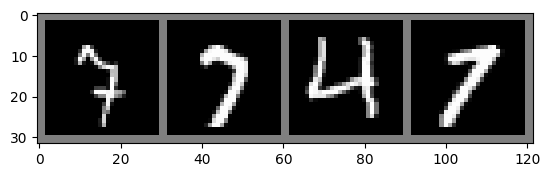

7 7 4 7


In [6]:
import torchvision.utils as utils
# Visualize the MNIST Dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images[:4]))
# Print labels
print(' '.join(f'{labels[j]}' for j in range(4)))
 

# Generator and Discriminator (10 marks)

Next lets set up the main charecters of our GAN, the generator and the discriminator. Starting of with the generator, feel free to use, whatever sort of architecture you feel suits you, just make sure to use the right activation functions and normalization layers, and that both the generator and the discriminator are able to work with the right size of images.

Feel free to reshape the tensor before passing it through the model, u may explicitly need to do this in atleast one of the models. 

In [7]:
# Code the Generator Model here
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, img_shape),
            nn.Tanh()  # Tanh activation function for generating images in [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# class Generator(nn.Module):
#     def __init__(self, latent_dim, img_shape):
#         super(Generator, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(latent_dim, 32),
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(0.2),
#             nn.Linear(64, 128),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, img_shape),
#             # nn.Dropout(0.3),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         return self.model(x)

In [8]:
# Code the Discriminator Model here
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Sigmoid activation function for binary classification
        )

    def forward(self, x):
        return self.model(x)
# class Discriminator(nn.Module):
#     def __init__(self, img_shape):
#         super(Discriminator, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(img_shape, 128),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),  # Adding dropout for regularization
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),  # Adding dropout for regularization
#             nn.Linear(64, 32),
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),  # Adding dropout for regularization
#             nn.Linear(32, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

In [9]:
latent_dim = 100  # Dimensionality of the latent space
img_shape = 28*28  # Shape of the generated images (assuming MNIST-like images)

# create instances of the Generator and Discriminator
# generator = Generator(latent_dim, img_shape)
# discriminator = Discriminator(img_shape)
# Instantiate the Generator
generator = Generator(latent_dim)

# Instantiate the Discriminator
discriminator = Discriminator()


In [10]:
# Print out the models for inspection
print(generator)
print(discriminator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.

# Loss and optimizers

Just like that, were done with the models, now lets set up the loss function and the optimizers for both the models.
For the the timme being do not change them, the given models are pretty standard, and conventional for image gen via GANs.

Other parameters however, you can change, and experiment with, such as the Epochs for example, feel free to experiment with these, and see what works best for you.

In [11]:
# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop (5 marks)

Now we have to load the data (preprocess it or do some image augmentation if you need) and train the model. 

Lets have brief look at how the loop for a vanilla GAN looks like, and then you can implement it yourself.

Each epoch involves a couple of steps:
1. Prep some data both fake and real
2. Train the discriminator with some real data
3. Train the discriminator with some fake data
3. Train the generator

The rest of its pretty similar to pytorch training loops, similar to the ones youve done in previous assingments.

In [12]:
num_epochs = 100

# Training Loop

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator with real images
        discriminator.zero_grad()
        real_images = real_images.view(batch_size, -1)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        d_loss_real.backward()

        # Train Discriminator with fake images
        z = torch.randn(batch_size, latent_dim)
        fake_images = generator(z)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                f"Discriminator Loss: {(d_loss_real + d_loss_fake).item():.4f}, "
                f"Generator Loss: {g_loss.item():.4f}"
            )

# Save the trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]

# Display images (2 marks)

Just display an image here using your generator model

In [ ]:
# Load the trained generator model
generator = Generator(latent_dim, img_shape)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()  # Set the model to evaluation mode

# Generate a random noise vector
z = torch.randn(1, latent_dim)

# Generate an image using the generator
with torch.no_grad():
    generated_image = generator(z).view(28, 28)  # Assuming MNIST image size

# Convert the generated image tensor to a numpy array
generated_image = generated_image.numpy()

# Display the generated image
plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()

# Setting up latent space interpolation  


Alright then, now that we are done with generating images, next lets take a look at the models latent space. 

What is it, and how do we use it?

The latent space is the space of all possible inputs that the generator can take, and it is a vector space, and since it is a vector space we can do some vector operations on it, such as interpolation, which is what we will be doing here.

To read up more on this, you can visit the following link: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/ this is a pretty good article on the topic, which also talks about an implementation of this, we will be doing something similar here.

So what you have to do here is generate two images of random numbers, once you have done this you have to interpolate between them, and display the images at each step of the interpolation.

# Latent space time (5 marks)


Now that we have the images, lets interpolate between them, So what you have to do here is generate two images of random numbers, once you have done this you have to interpolate between them, and display the images at each step of the interpolation, the result here should be a series of images that show how the generator is transitioning from one image to another, how it goes from an image of 3 it generated to an image of 7 for example.

Please make sure that there are atleast 10 steps including, the final and starting images.

In [ ]:
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = torch.linspace(0, 1, steps=n_steps).unsqueeze(1)  # Add an extra dimension for broadcasting
    # linear interpolate vectors
    vectors = (1.0 - ratios) * p1 + ratios * p2
    return vectors


# Generate two random points in the latent space
point1 = torch.randn(1, latent_dim)
point2 = torch.randn(1, latent_dim)

# Interpolate between them
interpolated_points = interpolate_points(point1, point2)

# Use the generator to create images from these interpolated points
with torch.no_grad():
    interpolated_images = generator(interpolated_points).view(-1, 28, 28).cpu().numpy()

# Display the images
fig, axs = plt.subplots(1, interpolated_images.shape[0], figsize=(15, 15))
for i, img in enumerate(interpolated_images):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.show()

# Vector arithmatic in the latent space (5 marks)

Ok, so if you were able to do that last part, one thing you may have noticed is that, in certain cases  when transitioning between one number and another, the image takes the form of some completely different number, for example, when transitioning from a 3 to a 6, the image may look like a 5 at some point, before going to a 6.

When we interpolate in this latent space, we're essentially taking a path from the representation of one digit to another. However, because this space is learned from the data and is designed to capture the underlying variations within it, the path between any two points can pass through regions that represent a mix of features from both endpoints. 

This is equivalent to doing arithmetic in the latent space, and it's a powerful tool for manipulating the representations of the data. For example, if we take the representation of the number 1 and add the representation of the number 0, we can obtain a new representation that captures the shared features of both numbers. something that resembles the circular shape of the 0, but also the vertical line segment of the one so a 9.

That is exactly what you have to do, this is what you have to do:

1. Generate 2 images
2. Perform additon on the latent space vectors of the images 
3. Display the results.

do this with atleast 3 different pairs of images.

In [ ]:
# display two random images from the generator, then dispaly there additon.

# Set the dimensionality of the latent space
latent_dim = 100

# Generate two random latent vectors
z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

# Generate images from these latent vectors
with torch.no_grad():
    img1 = generator(z1).view(28, 28).cpu().numpy()
    img2 = generator(z2).view(28, 28).cpu().numpy()

# Display the two original images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Image 1')
ax[0].axis('off')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('Image 2')
ax[1].axis('off')
plt.show()

# Perform "addition" in the latent space by averaging the two latent vectors
z_new = (z1 + z2) / 2

# Generate a new image from the combined latent vector
with torch.no_grad():
    new_img = generator(z_new).view(28, 28).cpu().numpy()

# Display the resulting image
plt.imshow(new_img, cmap='gray')
plt.title('Resulting Image')
plt.axis('off')

In [ ]:
# display two random images from the generator, then dispaly there additon.
# display two random images from the generator, then dispaly there additon.

# Set the dimensionality of the latent space
latent_dim = 100

# Generate two random latent vectors
z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

# Generate images from these latent vectors
with torch.no_grad():
    img1 = generator(z1).view(28, 28).cpu().numpy()
    img2 = generator(z2).view(28, 28).cpu().numpy()

# Display the two original images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Image 1')
ax[0].axis('off')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('Image 2')
ax[1].axis('off')
plt.show()

# Perform "addition" in the latent space by averaging the two latent vectors
z_new = (z1 + z2) / 2

# Generate a new image from the combined latent vector
with torch.no_grad():
    new_img = generator(z_new).view(28, 28).cpu().numpy()

# Display the resulting image
plt.imshow(new_img, cmap='gray')
plt.title('Resulting Image')
plt.axis('off')

# Some Analytical questions (5)

Q1) What would happen if you were to reduce the size of the dataset to 1/2 the number of images, and then train the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with the 1/2 the dataset
2. Generate images using this newly trained model
3. Along with a couple of images give reasoning for the results, as well as a description of the results.

Ans here:

Q2) What would happen if you were to change the loss function of the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with a different loss function, this could be any other loss function, it could be any of your choosing.
2. Generate images using this newly trained model.
3. Along with a couple of images give reasoning for the results, as well as a description of the results.

Ans here: